# NN back progation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib 
import scipy.optimize as opt
from sklearn.metrics import classification_report 

In [4]:
def load_data (path ,transpose = True ):
    data = sio.loadmat(path)
    y = data.get('y')
    print(y.shape)
    y = y.reshape(y.shape[0])
    X = data.get('X')
    if transpose :
        X = np.array([im.reshape((20,20)).T for im in X])
        
        X = np.array([im.reshape(400) for im  in X])
        
    return X,y

In [5]:
X, y = load_data('ex4data1.mat')

(5000, 1)


In [10]:
def plot_100_image(X):
    size = int(np.sqrt(X.shape[1]))
    
    sample_idx = np.random.choice(np.arange(X.shape[0]),100)
    sample_images = X[sample_idx, :]
    
    fig, ax_array = plt.subplots(nrows = 10,ncols = 10,sharey=True,sharex=True,figsize=(8,8))
    
    for r in range(10):
        for c in range(10):
            ax_array[r,c].matshow(sample_images[10*r+c].reshape((size,size)),
                                 cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
            

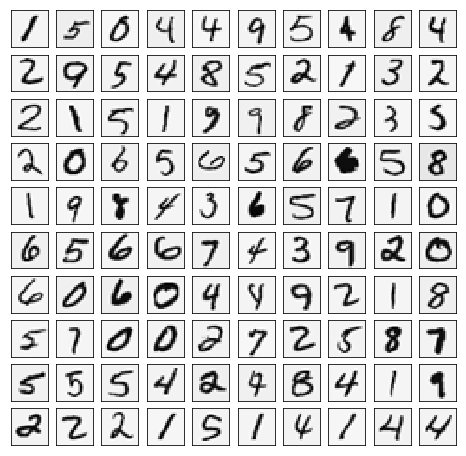

In [11]:
plot_100_image(X)
plt.show()

# 代价函数

In [12]:
X_raw , y_raw = load_data('ex4data1.mat',transpose=False)
X = np.insert(X_raw , 0, np.ones(X_raw.shape[0]), axis = 1)
X.shape

(5000, 1)


(5000, 401)

In [13]:
y_raw

array([10, 10, 10, ...,  9,  9,  9], dtype=uint8)

In [16]:
def expend_y(y):
    res = []
    for i  in y:
        y_array = np.zeros(10)
        y_array[i - 1] = 1
        res.append(y_array)
    return np.array(res)

In [17]:
y = expend_y(y_raw)
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

# 读取权重

In [18]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'],data['Theta2']

In [19]:
t1 , t2 = load_weight('ex4weights.mat')
t1.shape ,t2.shape

((25, 401), (10, 26))

In [20]:
def serialize(a,b):
    return np.concatenate ((np.ravel(a),np.ravel(b)))


In [21]:
theta = serialize(t1,t2)
theta.shape

(10285,)

# feed forward（前向传播）
> (400 + 1) -> (25 + 1) -> (10)

<img style="float: left;" src="../img/nn_model.png">

In [23]:
def feed_forward(theta ,X):
    t1 ,t2= deserialize(theta)
    m = X.shape[0]
    a1 = X
    
    z2 = a1 @t1.T
    a2 = np.insert(sigmoid(z2),0,np.ones(m),axis=1)
    
    z3 = a2 @t2.T
    h  = sigmoid(z3)
    
    return a1,z2,a2,z3,h

In [24]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [25]:
def deserialize(seq):
    return seq[:25*401].reshape(25,401),seq[25*401:].reshape(10,26)

In [26]:
_,_,_,_,h = feed_forward(theta,X)

In [28]:
h,h.shape

(array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
         4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
        [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
         2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
        [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
         6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
        ...,
        [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
         2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
        [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
         1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
        [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
         5.73434571e-03, 6.96288990e-01, 8.18576980e-02]]), (5000, 10))

# 代价函数
<img style="float: left;" src="../img/nn_cost.png">

think about this, now we have $y$ and $h_{\theta} \in R^{5000 \times 10}$  
If you just ignore the m and k dimention, pairwisely this computation is trivial.  
the eqation $= y*log(h_{\theta}) - (1-y)*log(1-h_{\theta})$  
all you need to do after pairwise computation is sums this 2d array up and divided by m

In [33]:
def cost(theta ,X ,y):
    m = X.shape[0]
    
    _,_,_,_,h = feed_forward(theta , X)
    pair_computation = -np.multiply(y,np.log(h)) - np.multiply((1 -y),np.log(1-h))
    
    return pair_computation.sum()/m

In [34]:
cost(theta ,X,y)

0.2876291651613189

In [80]:
def regularized_cost(theta, X, y, l=1):
    """the first column of t1 and t2 is intercept theta, ignore them when you do regularization"""
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    reg_t1 = (l / (2 * m)) * np.power(t1[:, 1:], 2).sum()  # this is how you ignore first col
    reg_t2 = (l / (2 * m)) * np.power(t2[:, 1:], 2).sum()

    return cost(theta, X, y) + reg_t1 + reg_t2

# 反向传播

In [35]:
X.shape, y.shape

((5000, 401), (5000, 10))

In [36]:
t1.shape , t2.shape

((25, 401), (10, 26))

In [37]:
theta.shape

(10285,)

In [39]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))


In [40]:
sigmoid_gradient(0)

0.25

# theta gradient
super hard to get this right... the dimension is so confusing

In [48]:
def gradient(theta ,X ,y):
    t1 , t2 = deserialize(theta)
    m = X.shape[0]
    
    delta1 = np.zeros(t1.shape)
    delta2 = np.zeros(t2.shape)
    
    a1,z2,a2,z3,h = feed_forward(theta,X)
    
    for i in range(m):
        a1i = a1[i ,:]
        a2i = a2[i ,:]
        z2i = z2[i ,:]
        
        hi = h[i,:]
        yi = y[i,:]
        
        d3i = hi - yi
        z2i = np.insert(z2i, 0, np.ones(1))
        d2i = np.multiply(t2.T @ d3i,sigmoid_gradient(z2i))
        
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    return serialize(delta1 , delta2)

In [49]:
d1 , d2  = deserialize(gradient(theta ,X,y))

In [50]:
d1.shape,d2.shape

((25, 401), (10, 26))

# 梯度校验
<img style="float: left;" src="../img/gradient_checking.png">

In [75]:
def gradient_checking(theta ,X,y,epsilon,regularized = False):
    def a_numeric_grad(plus , minus, regularized=False):
        if regularized:
            return (regularized_cost(plus,X,y) - regularized_cost(minus,X,y))/(epsilon*2)
        else:
            return (cost(plus,X,y) - cost(minus,X,y)) /(epsilon *2)
    theta_matrix = expand_array(theta)
    epsilon_matrix = np.identity(len(theta)) * epsilon
    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix
    
    numeric_grad = np.array([a_numeric_grad(plus_matrix[i],minus_matrix[i],regularized)
                             for i  in range(len(theta))])
    analytic_grad = regularized_gradient(theta,X,y) if regularized else gradient(theta,X,y)
    
    diff = np.linalg.norm(numeric_grad - analytic_grad)/np.linalg.norm(numeric_grad + analytic_grad)
    
    print ('If you backpropagation implementation is correct, \n the relative difference will be smaller than 10e-9(assume epsilon = 0.0001).\nRelative Difference: {}\n'.format(diff))
    

In [76]:
def expand_array(arr):
    
    #return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))

 """replicate array into matrix
    [1, 2, 3]

    [[1, 2, 3],
     [1, 2, 3],
     [1, 2, 3]]
    """

In [77]:
gradient_checking(theta ,X ,y,epsilon = 0.001)

If you backpropagation implementation is correct, 
 the relative difference will be smaller than 10e-9(assume epsilon = 0.0001).
Relative Difference: 2.065478274635361e-07



# regularized gradient
Use normal gradient + regularized term

<img style="float: left;" src="../img/nn_reg_grad.png">

In [86]:
def regularized_gradient(theta ,X,y, l=1):
    m = X.shape[0]
    delta1, delta2 = deserialize(gradient(theta ,X,y))
    t1 ,t2 = deserialize(theta)
    
    t1[:,0] = 0 
    reg_term_d1 = (1 / m) *t1 
    delta1 = delta1 + reg_term_d1
    
    t2[:,0] = 0
    reg_term_d2 = (1 / m) *t2
    delta2 = delta2 + reg_term_d2
    
    return serialize(delta1,delta2)

In [87]:
gradient_checking(theta ,X,y,epsilon=0.01,regularized =True)

If you backpropagation implementation is correct, 
 the relative difference will be smaller than 10e-9(assume epsilon = 0.0001).
Relative Difference: 3.994783358597085e-06



# ready to train the model 

remember to randomly initlized the parameters to break symmetry

take a look at the doc of this argument: `jac`

>jac : bool or callable, optional
Jacobian (gradient) of objective function. Only for CG, BFGS, Newton-CG, L-BFGS-B, TNC, SLSQP, dogleg, trust-ncg. **If jac is a Boolean and is True, fun is assumed to return the gradient along with the objective function.** If False, the gradient will be estimated numerically. jac can also be a callable returning the gradient of the objective. In this case, it must accept the same arguments as fun.

it means if your `backprop` function return `(cost, grad)`, you could set `jac=True`  

This is the implementation of http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/ml/ML-Exercise4.ipynb

but I choose to seperate them

In [89]:
def random_init(size):
    return np.random.uniform(-0.12 ,0.12,size)

In [92]:
def nn_training(X,y):
    init_theta = random_init(10285)
    res = opt.minimize(fun = regularized_cost,
                      x0 = init_theta,
                      args = (X ,y ,1),
                      method = 'TNC',
                      jac = regularized_gradient,
                      options = {'maxiter':400}
                      )
    return res


In [93]:
res = nn_training(X ,y)
res

     fun: 0.3202536183707116
     jac: array([ 2.48427366e-04, -3.02482272e-08,  4.34970048e-08, ...,
       -4.62970716e-05, -2.50115474e-04, -3.04955600e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 26
  status: 3
 success: False
       x: array([ 0.00000000e+00, -1.51241136e-04,  2.17485024e-04, ...,
       -2.27791582e+00,  5.52915438e-01, -6.55658211e-01])

# 显示准确率

In [94]:
_, y_answer = load_data('ex4data1.mat')
y_answer[:20]

(5000, 1)


array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10], dtype=uint8)

In [95]:
final_theta  = res.x 

In [96]:
def show_accuracy(theta ,X,y):
    _,_,_,_,g = feed_forward(theta,X)
    y_pred = np.argmax(h,axis =1) +1 
    
    print (classification_report(y,y_pred))

# show hidden

In [133]:
def plot_hidden_layer(theta):
    final_theta1, _ = deserialize(theta)
    print (final_theta1.shape)
    hidden_layer  = final_theta1[:,1:]
    print (hidden_layer.shape)
    
    fig ,ax_array = plt.subplots(nrows = 5,ncols = 5,sharey= True,sharex=True ,figsize=(5,5))
    
    for r in range(5):
        for c in range(5):
            ax_array[r,c].matshow(hidden_layer[ 5*r +c].reshape((20,20)),
                                 cmap = matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
            
    

(25, 401)
(25, 400)


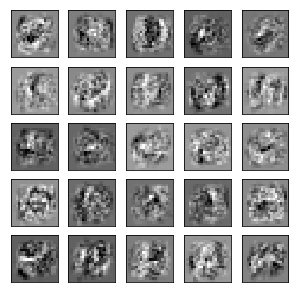

In [134]:
plot_hidden_layer(final_theta)
plt.show()